In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
# Load in the csv dataset and view
df = pd.read_csv('/Users/apple/Desktop/Methanol Synthesis Project/data/prepared_yield_dataset.csv')
df.head()

,Temperature (K),Pressure (bar),Residence Time (s)_1,Residence Time (s)_2,Total res time,Res time ratio,Pressure/Temp,Temp_Pressure,Temp/Total time,Press/Total time,Overall Yield,Yield_boxcox
0,480.630829,91.621243,18.100214,13.236934,31.337148,1.367402,0.190627,44035.993833,15.337414,2.923726,0.390921,-0.413251
1,550.991879,68.001329,6.006925,24.561671,30.568596,0.244565,0.123416,37468.179862,18.024769,2.224549,0.526929,-0.354371
2,516.840923,70.676729,17.977576,19.551870,37.529446,0.919481,0.136748,36528.625800,13.771611,1.883234,0.531930,-0.351847
3,545.346518,95.531033,15.972852,16.805256,32.778108,0.950468,0.175175,52097.516165,16.637523,2.914477,0.565548,-0.334214
4,570.798951,54.649330,17.036762,22.303915,39.340676,0.763846,0.095742,31193.780164,14.509129,1.389130,0.750000,-0.216622


## __Train-Test Split__

- Split the data from dataset into features and targets
- split data further into training (75%) and testing (25%) data 

In [4]:
# Function for preprocessing step
def preprocess_datset(df):
    # Preparing features from the dataset column for splitting
    features = ['Temperature (K)','Pressure (bar)','Residence Time (s)_1','Residence Time (s)_2','Total res time','Res time ratio','Pressure/Temp','Temp_Pressure','Temp/Total time','Press/Total time']
    # splitting into X(features) and y(targets)
    X = df[features]
    y = df['Yield_boxcox'] # Recall that 'Yield_boxcox' is the target not 'Overall Yield' due to initial skewed distribution of 'Overall yield'
    return X,y

X,y = preprocess_datset(df)    

In [5]:
# Further splitting into training and testing data
def train_test_splits(X,y,test_size=0.25):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=0)
    return X_train,X_test,y_train,y_test

# Split data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y)    

## __Model Selection__

This stage includes
- Test Dummy Regressor to check baseline performance of models
- Check baseline models and pick the best using Cross validation comparing models based on the $R^2$ of each model

### __Test Dummy Regressor__

In [6]:
# Function to view baseline performance of the models
def dummy_regressor(X_train,X_test,y_train,y_test):
    # Initialize and train dummy regressor
    dummy = DummyRegressor(strategy='mean')
    dummy.fit(X_train,y_train)

    # Predict with regressor and evaluate performances
    y_pred_dummy = dummy.predict(X_test)
    y_dummy_r2_score = r2_score(y_test,y_pred_dummy)
    y_dummy_mse = root_mean_squared_error(y_test,y_pred_dummy)

    # Print performances
    print(f'The r2-score of dummy model is {y_dummy_r2_score}')
    print(f'The root mean squared error of dummy model is {y_dummy_mse}')

dummy_regressor(X_train,X_test,y_train,y_test)    

The r2-score of dummy model is -0.0001695019552696575
The root mean squared error of dummy model is 0.0525617040370596


__Interpretation of Dummy Regressor Scores__

1. The dummy model's R² score near zero (and slightly negative) indicates that it fails to explain any variability in the target — essentially no better than guessing the mean.
2. An RMSE of 0.0526 gives a reference error value. Any useful model should outperform this.

This baseline helps validate the need for more complex, feature-based models, and gives a benchmark for measuring their added value.

### __Model Selection with Cross-Validation__

To identify a strong baseline model, I evaluated a mix of linear and non-linear regressors: Linear Regression, Ridge, Random Forest, and XGBoost. These were chosen to compare simple interpretable models with more powerful tree-based methods.

I used 5-fold cross-validation to assess each model's generalization performance. This helps reduce bias from a single train-test split and gives insight into model stability across different data subsets.


Linear Regression model: mean of cv_scores = 0.8868, variability of cv_scores = 0.0148
Ridge model: mean of cv_scores = 0.8694, variability of cv_scores = 0.0179
Random Forest model: mean of cv_scores = 0.9851, variability of cv_scores = 0.0026
XGBoost model: mean of cv_scores = 0.9844, variability of cv_scores = 0.0027


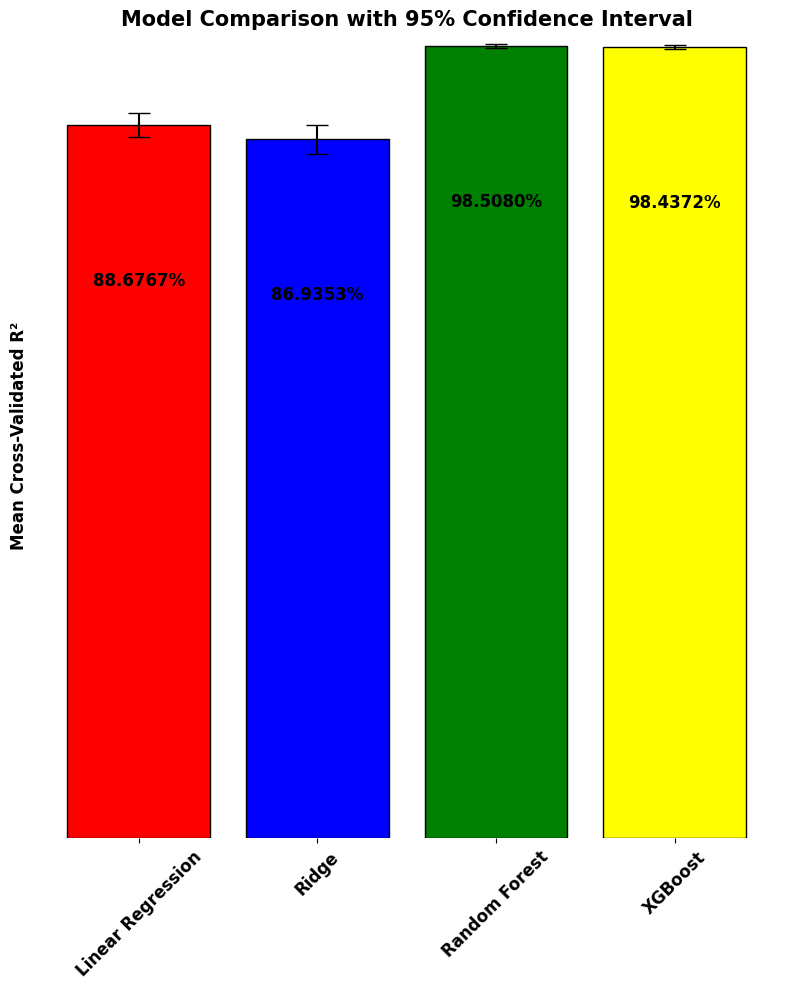

In [7]:
# Function for model selection with cross validation
def model_selection(X_train,y_train,cv=5,scoring='r2'):
    # Linear and non-linear models mix we evaluated
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=7),
        'Random Forest': RandomForestRegressor(random_state=7),
        'XGBoost': XGBRegressor(random_state=7, eval_metric='rmse')
    }

    # Initialize dictionary to store results
    results = {}

    # Loop that performs cross validation for all models and returns the mean perfromance score of each
    for name, model in models.items():
        # Data Pipeline for scaling and modelling 
        # Scaling is important for some models, especially after scaling was not carried out during data preparation
        pipeline = Pipeline([
            ('scaler',StandardScaler()), 
            ('model',model)
        ])
        # Cross validation
        cv_scores = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='r2')
        
        # Update dictionary with scores 
        results[name] = cv_scores
        # Print performance scores
        print(f'{name} model: mean of cv_scores = {cv_scores.mean():.4f}, variability of cv_scores = {cv_scores.std()*2:.4f}')

    # Prepare data for plotting to show performance scores
    model_names = list(results.keys())
    means = [scores.mean() for scores in results.values()]
    errors = [scores.std() * 2 for scores in results.values()]  # 95% CI
    colours = ['red','blue','green','yellow']

    # Plotting with Matplotlib
    plt.figure(figsize=(8, 10))
    bars = plt.bar(model_names, means, yerr=errors, capsize=8, color=colours, edgecolor='black')
    plt.ylabel('Mean Cross-Validated R²',fontsize=12,fontweight='bold')
    plt.title('Model Comparison with 95% Confidence Interval',fontsize=15,fontweight='bold')
    plt.xticks(rotation=45, fontsize=12, fontweight='bold')
    plt.yticks([])
    plt.ylim(0, 1)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.2, f"{height * 100:.4f}%",
                    ha='center', color='black', fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.show()


model_selection(X_train,y_train)

With a mean Cross validation score value of 0.9850 and a variability of 0.0023, Random Forest has the best mean metric ($R^2$) score and the lowest varability which means the model explains about 98.5% of the variance in the target variable during training, while the low variability (standard deviation × 2) suggests that its performance is stable and consistent across all folds.

Therefore we choose Random Forest as our model, next is hyperparameter tuning of our chosen model

## __Hyperparameter Tuning__

This step is to optimize the selected model to maximize generalization.

In [8]:
# Function for hyperparameter tuning
def hyperparameter_tuning(X_train,y_train,cv=5,scoring='r2'):
    # Random forest being a tree based model does not require scaling, so it is excluded from the pipeline
    model = Pipeline([
        ('model',RandomForestRegressor(random_state=7))
    ])

    # Parameters to iterate from to find ideal parameter combination that gives best generalization
    param_grid = {
        'model__n_estimators': [10 ,50, 100, 200],
        'model__max_depth': [2,5,10,20],
        'model__min_samples_split': [2,5,10]
    }

    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(model,param_grid=param_grid,cv=cv,scoring=scoring,n_jobs=-1)
    grid_search.fit(X_train,y_train)

    # View best parameter combination and performance of best generalization model
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best CV R² After Tuning: {grid_search.best_score_:.4f}")

    # Extract the best generalization model (with its best hyperparameters) found by GridSearchCV and stores it in the variable best_model
    best_model = grid_search.best_estimator_

    return best_model

best_model = hyperparameter_tuning(X_train,y_train)    

Best Parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV R² After Tuning: 0.9853


## __Model Evaluation__

Here we take the following steps to evaluate and further imporve our trained model
1. Retrain the best model using selected features (based on feature importance) and validate it. Proceed to drop features with negligible contribution from data used to train model
2. Retrain model with improved training data and evaluate metrics on the test set:
    - Get R², MSE/RMSE, MAE.
3. Save model for future deployment    
4. Find inverse-transform predictions (Box-Cox) for interpretability. and use this to plot  actual vs predicted evaluation and residuals plots.



/var/folders/1_/wks594vd2m92nsrd4rjjy3r00000gn/T/ipykernel_2786/217306871.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Spectral')


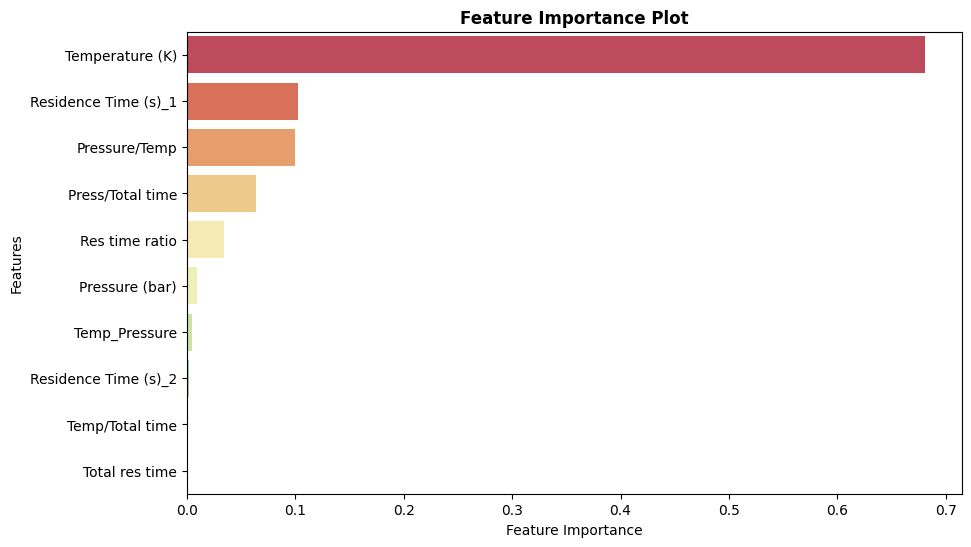

Selected Features: ['Temperature (K)', 'Residence Time (s)_1', 'Pressure/Temp', 'Press/Total time']


In [9]:
def feature_importance_analysis(model,X_train,y_train,X_test,threshold=0.05):
    # Train model
    model.fit(X_train,y_train)

    # Access feature importance from model
    rf_model = model.named_steps['model']
    feature_importance = rf_model.feature_importances_

    # Prepare dataframe of features and thier respective feature importance for viewing and plotting
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plotting the feature importance of the different features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Spectral')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance Plot',fontweight='bold')
    plt.show()

    # Get list of features to keep
    important_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()

    # Print selected features
    print("Selected Features:", important_features)

    # This returns the updated dataset to use for improved modelling as the important features fro probable future use
    return important_features

important_features = feature_importance_analysis(best_model,X_train,y_train,X_test)    

In [10]:
# Now, perform Cross validation on model with updated features to check if perfromance remains robust
def validate_feature_importance(model, X_train, y_train, cv=5, scoring='r2'):

    # Apply reduced features to training set
    X_train_reduced = X_train[important_features]
    
    # Compute cross-validation scores on reduced feature set
    cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=cv, scoring=scoring)
    print(f"CV R² with reduced features: {cv_scores.mean():.4f} (± {cv_scores.std() * 2:.4f})")
    
    # Compare with full feature set
    cv_scores_full = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    print(f"CV R² with full features: {cv_scores_full.mean():.4f} (± {cv_scores_full.std() * 2:.4f})")

validate_feature_importance(best_model, X_train, y_train)

CV R² with reduced features: 0.9821 (± 0.0027)
CV R² with full features: 0.9853 (± 0.0027)


Feature importance analysis led to the removal of low-impact features, reducing model complexity. Cross-validation results show minimal performance degradation (R²: 0.9853 → 0.9821), confirming that the most predictive features were retained. This validates the effectiveness of the feature selection strategy.

We now proceed to reduce the feature sets (X_train and X_test) by selecting only the important features identified during feature importance analysis. This prepares the data for final model evaluation using the optimized feature subset.

In [11]:
X_train = X_train[important_features]
X_test = X_test[important_features]

The feature sets have been successfully reduced. The datasets are now ready for final evaluation of the model.

In [12]:
def final_model_evaluation(model):
    # Train model
    best_model.fit(X_train,y_train)

    # predict unseen test data
    y_pred = model.predict(X_test)

    # Compute performance metrics of model and print
    y_pred_r2_score = r2_score(y_test,y_pred)
    y_pred_rmse = root_mean_squared_error(y_test,y_pred)

    print(f'The r2-score of the best model is {y_pred_r2_score:.4f}')
    print(f'The root mean squared error of the best model is {y_pred_rmse:.4f}')

final_model_evaluation(best_model)    

The r2-score of the best model is 0.9872
The root mean squared error of the best model is 0.0060


__Model Performance Summary__

$R^2$ Score: 0.9872

1. This means your model explains 98.72% of the variance in the target variable.
2. In other words, the model fits the data extremely well — almost all of the variability in the target can be accounted for by the model’s predictions.

Root Mean Squared Error (RMSE): 0.0060

1. RMSE measures the average error magnitude between predicted and actual values, in the same unit as your target variable.
2. A low RMSE like 0.0060 indicates your model’s predictions are very close to the actual values.

In [13]:
# Save model for future use
joblib.dump(best_model,'/Users/apple/Desktop/Methanol Synthesis Project/objects/best_model.pkl')

['/Users/apple/Desktop/Methanol Synthesis Project/objects/best_model.pkl']

/Users/apple/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/apple/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


R² Score (Original Scale): 0.9897
Mean Squared Error (Original Scale): 0.0139


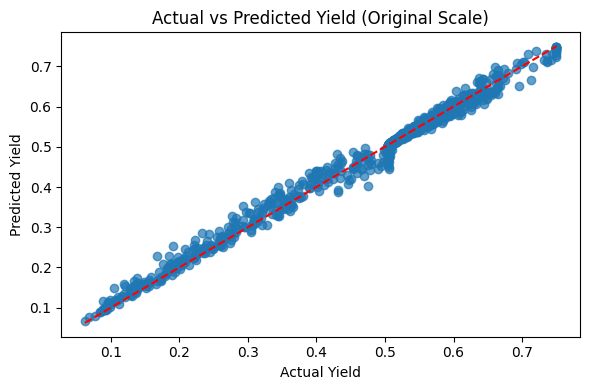

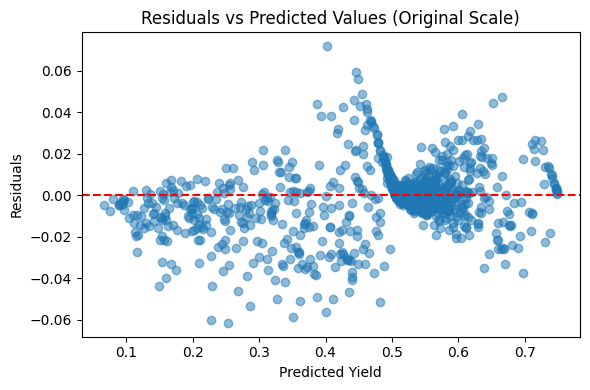

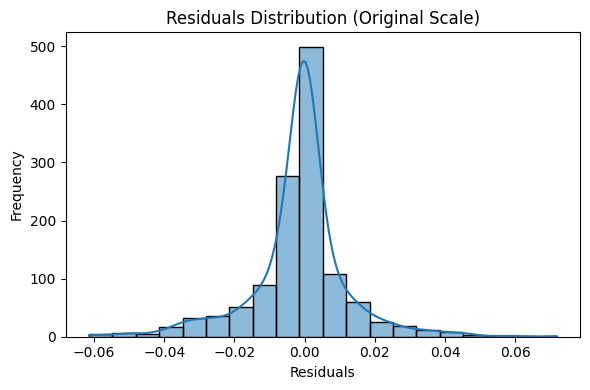

(0.9896651707679033, np.float64(0.013926414175422931))

In [14]:
def evaluate_model_on_original_scale(model, X_test, y_test, transformer_path='/Users/apple/Desktop/Methanol Synthesis Project/objects/yield_boxcox_transformer.pkl'):
    """
    Evaluates a regression model's performance on the original (inverse-transformed) target scale,
    using R², MSE, and visualizations of predictions and residuals.

    Parameters:
    - model: Trained pipeline model (e.g. Pipeline with scaler and regressor)
    - X_test: Test features
    - y_test: True test labels (Box-Cox transformed)
    - transformer_path: Path to saved Box-Cox transformer (default: 'yield_boxcox_transformer.pkl')
    
    Returns:
    - r2: R² score on original scale
    - mse: Mean Squared Error on original scale
    """
    # Load the saved Box-Cox transformer
    pt = joblib.load(transformer_path)
    
    # Predict using the model
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and true values to original scale
    y_test_original = pt.inverse_transform(y_test.to_numpy().reshape(-1, 1)).flatten()
    y_pred_original = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate residuals
    residuals = y_test_original - y_pred_original

    # Calculate metrics
    r2 = r2_score(y_test_original, y_pred_original)
    rmse = root_mean_squared_error(y_test_original, y_pred_original)
    
    print(f"R² Score (Original Scale): {r2:.4f}")
    print(f"Mean Squared Error (Original Scale): {rmse:.4f}")

    # Actual vs Predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_original, y_pred_original, alpha=0.7)
    plt.plot([min(y_test_original), max(y_test_original)],
             [min(y_test_original), max(y_test_original)], 'r--')
    plt.xlabel('Actual Yield')
    plt.ylabel('Predicted Yield')
    plt.title('Actual vs Predicted Yield (Original Scale)')
    plt.tight_layout()
    plt.show()
    
    # Residuals vs Predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred_original, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Yield')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values (Original Scale)')
    plt.tight_layout()
    plt.show()
    
    # Histogram of residuals
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title('Residuals Distribution (Original Scale)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    return r2, rmse

evaluate_model_on_original_scale(best_model,X_test,y_test)

__Model Evaluation (Original Scale)__

1. Actual vs Predicted Yield

This scatter plot compares the actual yield values with the predicted ones. The red dashed line represents the ideal scenario where predicted values perfectly match the actual ones (i.e., a 45-degree line).

Interpretation: The points closely follow the red line, indicating that the model performs well and makes accurate predictions on the original (inverse-transformed) scale.

2. Residuals vs Predicted Values

This plot shows the residuals (differences between actual and predicted values) against the predicted values.

Interpretation: Residuals are centered around zero, which is good. However, some structure or non-random patterns (e.g. tighter clustering around certain yield values) may indicate mild heteroscedasticity or model underfitting at those points.


3. Residuals Distribution

This histogram visualizes the distribution of residuals.

Interpretation: The residuals are symmetrically distributed and roughly bell-shaped, indicating that errors are normally distributed—a key assumption in many regression models.

__In conclusion:__
__The model is highly accurate, statistically sound, and suitable for yield prediction in this chemical process.__